# Libraries & Functions

In [1]:
import sys
import pickle
import pandas as pd
import pprint
from scipy import stats 

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Introduction


Source: __[Wikipedia](https://en.wikipedia.org/wiki/Enron)__

Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. It was founded in 1985 as a merger between Houston Natural Gas and InterNorth, both relatively small regional companies. Before its bankruptcy on December 2, 2001, Enron employed approximately 20,000 staff and was a major electricity, natural gas, communications and pulp and paper company, with claimed revenues of nearly $101 billion during 2000. Fortune named Enron "America's Most Innovative Company" for six consecutive years.

 At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalized, systematic, and creatively planned accounting fraud, known since as the Enron scandal. Enron has since become a well-known example of willful corporate fraud and corruption. The scandal also brought into question the accounting practices and activities of many corporations in the United States and was a factor in the enactment of the Sarbanes–Oxley Act of 2002. The scandal also affected the greater business world by causing the dissolution of the Arthur Andersen accounting firm, which had been Enron's main auditor for years. 

 Enron filed for bankruptcy in the Southern District of New York in late 2001 and selected Weil, Gotshal & Manges as its bankruptcy counsel. It ended its bankruptcy during November 2004, pursuant to a court-approved plan of reorganization. A new board of directors changed the name of Enron to Enron Creditors Recovery Corp., and emphasized reorganizing and liquidating certain operations and assets of the pre-bankruptcy Enron. On September 7, 2006, Enron sold Prisma Energy International Inc., its last remaining business, to Ashmore Energy International Ltd. (now AEI). 
 
<img src="878px-Logo_de_Enron.svg.png" alt="Enron Logo" title="Enron Logo" style="width: 300px;" />

# Project Case and Data Introduction

<div class="alert alert-block alert-info">
<h2>Project Case and Data Introduction</h2>
<br>
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those? Relevant rubric items: “data exploration”, “outlier investigation”
</div>

##### Loading data

In [88]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [89]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index':'full_name'}, inplace=True)

In [90]:
df.head(1)

,full_name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
0,ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN


In [91]:
continuous_features = ['salary', 'deferral_payments', 'total_payments', 
                      'loan_advances', 'bonus', 'restricted_stock_deferred', 
                      'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees', 'to_messages', 
                       'from_poi_to_this_person', 'from_messages', 
                       'from_this_person_to_poi', 'shared_receipt_with_poi']

email_features= ['to_messages', 'from_poi_to_this_person', 'from_messages',
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

for feat in continuous_features:
    df[feat]=df[feat].astype(float)

In [92]:
# check whether all rows with email information are complete
df[email_features].apply(lambda x: x==x).sum(axis=1).value_counts()

5    86
0    60
dtype: int64

**Project Goal**<br>
In this project, I will build a machine learning classifier that will identify persons of interest (POI) in a fraud case given a number of available features.

**Dataset**<br>
The dataset used for this project consists of {{df.shape[0]}} individual entries of possible persons of interest with {{df.shape[1]-1}} available features. In addition there are {{int(df.to_messages.sum())}} outgoing email messages and {{int(df.from_messages.sum())}} incoming email messages from 86 different mailboxes available that could also be used to generate a text classifier.

This dataset can be used to find persons that should be investigated further given the combination of values in the available features.

There were a large number of missing values in the dataset. Firstly I reviewed the data availability for each feature and filtered all columns that had less than 40% data availability (valid_features). Next, I reviewed the number of missing features for each row and removed all rows that had more than 17 missing features. Removing these rows also took care of a row that appears to be a business and not an individual: 'THE TRAVEL AGENCY IN THE PARK'.

**Outliers**<br>
After ploting boxplots for all valid_features, I found a row that was brought from the spreadsheet with the total sum for all columns and removed it.<br>
Creating boxplots again shows a more 'normal' number of outliers to be investigated. Results below:

- Salary: All high-valued outliers appear to be valid data points; however, low-valued datapoints appear to be incorrect. James Bannantine and Rodney Gray both held executive positions while Richard Westfahl served as managing director. The stated salaries appear to be too low for said positions. Nevertheless, I could not find any evidence that would point to a different salary and as such, the data found was used for the analysis. 
- BHATNAGAR SANJAY: This entry appeared in outliers on restricted and restricted deferred stock investigations. Restricted deferred stock appeared as a positive number, which would mean that the deferred stock was paid to the employee rather than being deferred for future payment. Upon further investigation I found that this entry had data entry errors which were corrected before proceeding with the analysis.

All other outliers appeared to be valid entries and were used for the analysis.

**Missing Data**<br>
After removing features with a large amount of missing data, missing datapoints were filled with zeroes. 


##### Exploring valid data

In [93]:
# proportion of available data
available_data = pd.DataFrame(
    [{'feature':f,
      'available':df[f].count(),
      'poi':df.query(f'{f}=={f} & poi==True')[f].shape[0],
      'total':df.shape[0]} 
     for f in continuous_features])
available_data=available_data[['feature','total','available','poi']]
available_data['prop_available']=available_data.available/available_data.total
available_data['prop_poi_total']=available_data.poi/available_data.total
available_data['propr_poi_available']=available_data.poi/available_data.available
available_data

,feature,total,available,poi,prop_available,prop_poi_total,propr_poi_available
0,salary,146,95,17,0.650685,0.116438,0.178947
1,deferral_payments,146,39,5,0.267123,0.034247,0.128205
2,total_payments,146,125,18,0.856164,0.123288,0.144000
3,loan_advances,146,4,1,0.027397,0.006849,0.250000
4,bonus,146,82,16,0.561644,0.109589,0.195122
5,restricted_stock_deferred,146,18,0,0.123288,0.000000,0.000000
6,deferred_income,146,49,11,0.335616,0.075342,0.224490
7,total_stock_value,146,126,18,0.863014,0.123288,0.142857
8,expenses,146,95,18,0.650685,0.123288,0.189474
9,exercised_stock_options,146,102,12,0.698630,0.082192,0.117647


In [94]:
valid_features = list(available_data[available_data.prop_available>=.4].feature)
valid_features

['salary',
 'total_payments',
 'bonus',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi']

In [95]:
# create column with number of missing values per row
df['missing_cols']=df.apply(lambda x: x!=x).sum(axis=1)

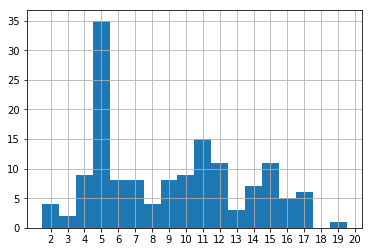

In [96]:
# plot distribution of missing values
binwidth=1
bins=np.arange(df.missing_cols.min(),df.missing_cols.max()+2*binwidth)
df.missing_cols.hist(bins=bins, align='left')
plt.xticks(bins);

In [97]:
# exploring proportion of rows with missing features
missing_values=df.pivot_table(values='full_name', index='missing_cols', 
                              aggfunc=len)
missing_values.rename(columns={'missing_cols': 'num_missing_features',
                               'full_name':'rows_count'}, inplace=True)
missing_values['cum_sum']=missing_values.rows_count.cumsum()
missing_values['rel_cum_sum']=missing_values.cum_sum/missing_values.rows_count.sum()
missing_values

,rows_count,cum_sum,rel_cum_sum
missing_cols,,,
2,4,4,0.027397
3,2,6,0.041096
4,9,15,0.102740
5,35,50,0.342466
6,8,58,0.397260
7,8,66,0.452055
8,4,70,0.479452
9,8,78,0.534247
10,9,87,0.595890


In [98]:
# exploring rows with >= 17 missing features
df.query('missing_cols>=17').sort_values(by='missing_cols')

,full_name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,missing_cols
56,GRAMM WENDY L,NaN,NaN,NaN,119292.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,119292.0,17
115,SCRIMSHAW MATTHEW,NaN,NaN,NaN,NaN,NaN,NaN,matthew.scrimshaw@enron.com,NaN,NaN,...,759557.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,17
127,THE TRAVEL AGENCY IN THE PARK,NaN,NaN,NaN,362096.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,362096.0,NaN,False,NaN,NaN,NaN,NaN,17
138,WHALEY DAVID A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98718.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,17
142,WODRASKA JOHN,NaN,NaN,NaN,189583.0,NaN,NaN,john.wodraska@enron.com,NaN,NaN,...,NaN,NaN,189583.0,NaN,False,NaN,NaN,NaN,NaN,17
143,WROBEL BRUCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,139130.0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,17
84,LOCKHART EUGENE E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,19


##### Outliers

In [99]:
def make_visualisations(df, features, vis='hist', n_cols=2, figsize=(15,40), 
                        bins=50, **kwds):
    '''
    Make histrograms or boxplots for all items in features list from a pandas 
    dataframe.
    Parameters
    - df: Pandas dataframe. Dataframe with all data.
    - features: List. List of features to be plotted. Must be numerical 
    features. NaN values will be dropped.
    - vis: Str. Type of visualisation: [hist or boxplot]
    - n_cols: Integer. Number of columns for the histogram matrix.
    - figsize: Tuple (w,h). Size of histograms matrix.
    - bins: Integer. Number of bins in the histogram.
    '''
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=.3)
    for i in range(len(features)):
        ax=fig.add_subplot(round(len(features)/n_cols+.5),n_cols,i+1)
        data=df[features[i]].dropna()
        if vis=='hist':
            ax.hist(data,bins=bins, **kwds)
        elif vis=='boxplot':
            ax.boxplot(data, **kwds)
        else:
            print('Invalid visualisation')
            break
        ax.title.set_text(features[i])
    plt.show()

In [100]:
def outliers(df, feature):
    """
    Returns rows that are considered outliers for a given feature.
    Outlier definition: (Q1-1.5IQR,Q3+1.5IQR)
    Parameters:
    - df: Pandas dataframe. Dataframe that contains data.
    - feature: Str. Name of feature to be explored.
    """
    iqr = stats.iqr(df[feature].dropna())
    third_quantile = df[feature].quantile(0.75)
    first_quantile = df[feature].quantile(0.25)
    outliers = (first_quantile-1.5*iqr,third_quantile+1.5*iqr)
    return df[(df[feature]<outliers[0]) | (df[feature]>outliers[1])][['full_name',feature]]\
    .sort_values(by=feature)

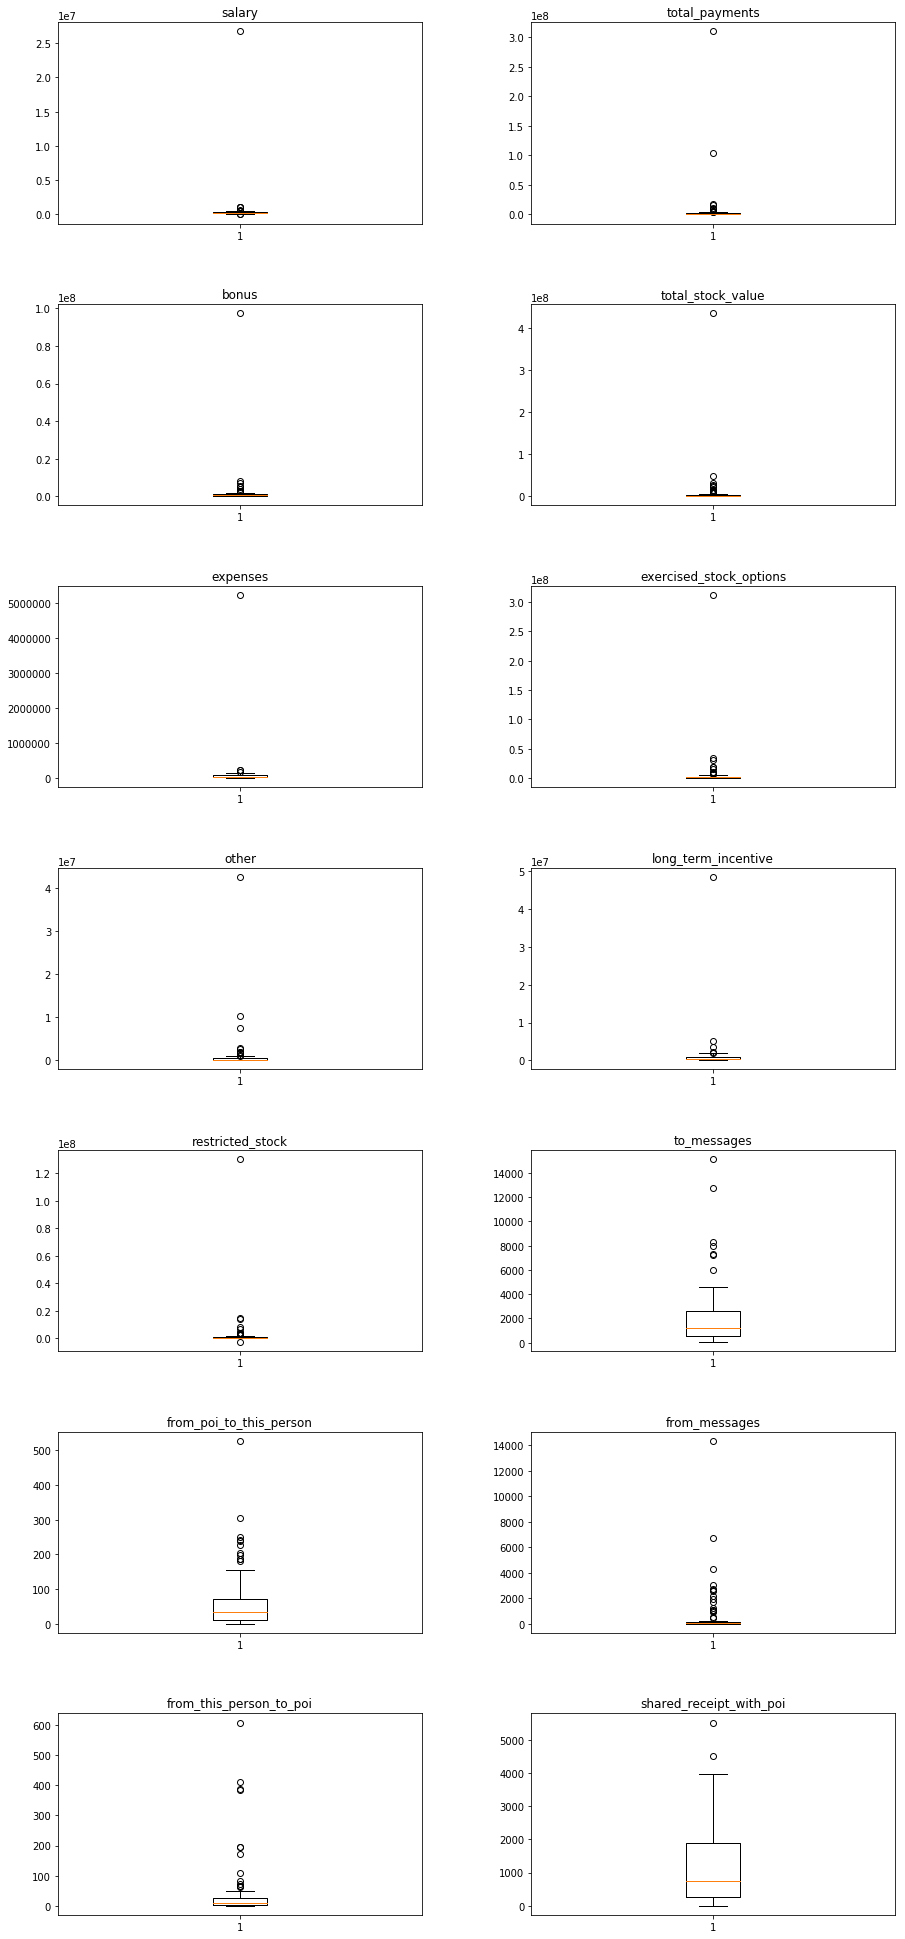

In [101]:
make_visualisations(df,valid_features,'boxplot')

In [102]:
print(df.shape)
df=df.query('full_name not in ["TOTAL","THE TRAVEL AGENCY IN THE PARK"]').copy()
print(df.shape)

(146, 23)
(144, 23)


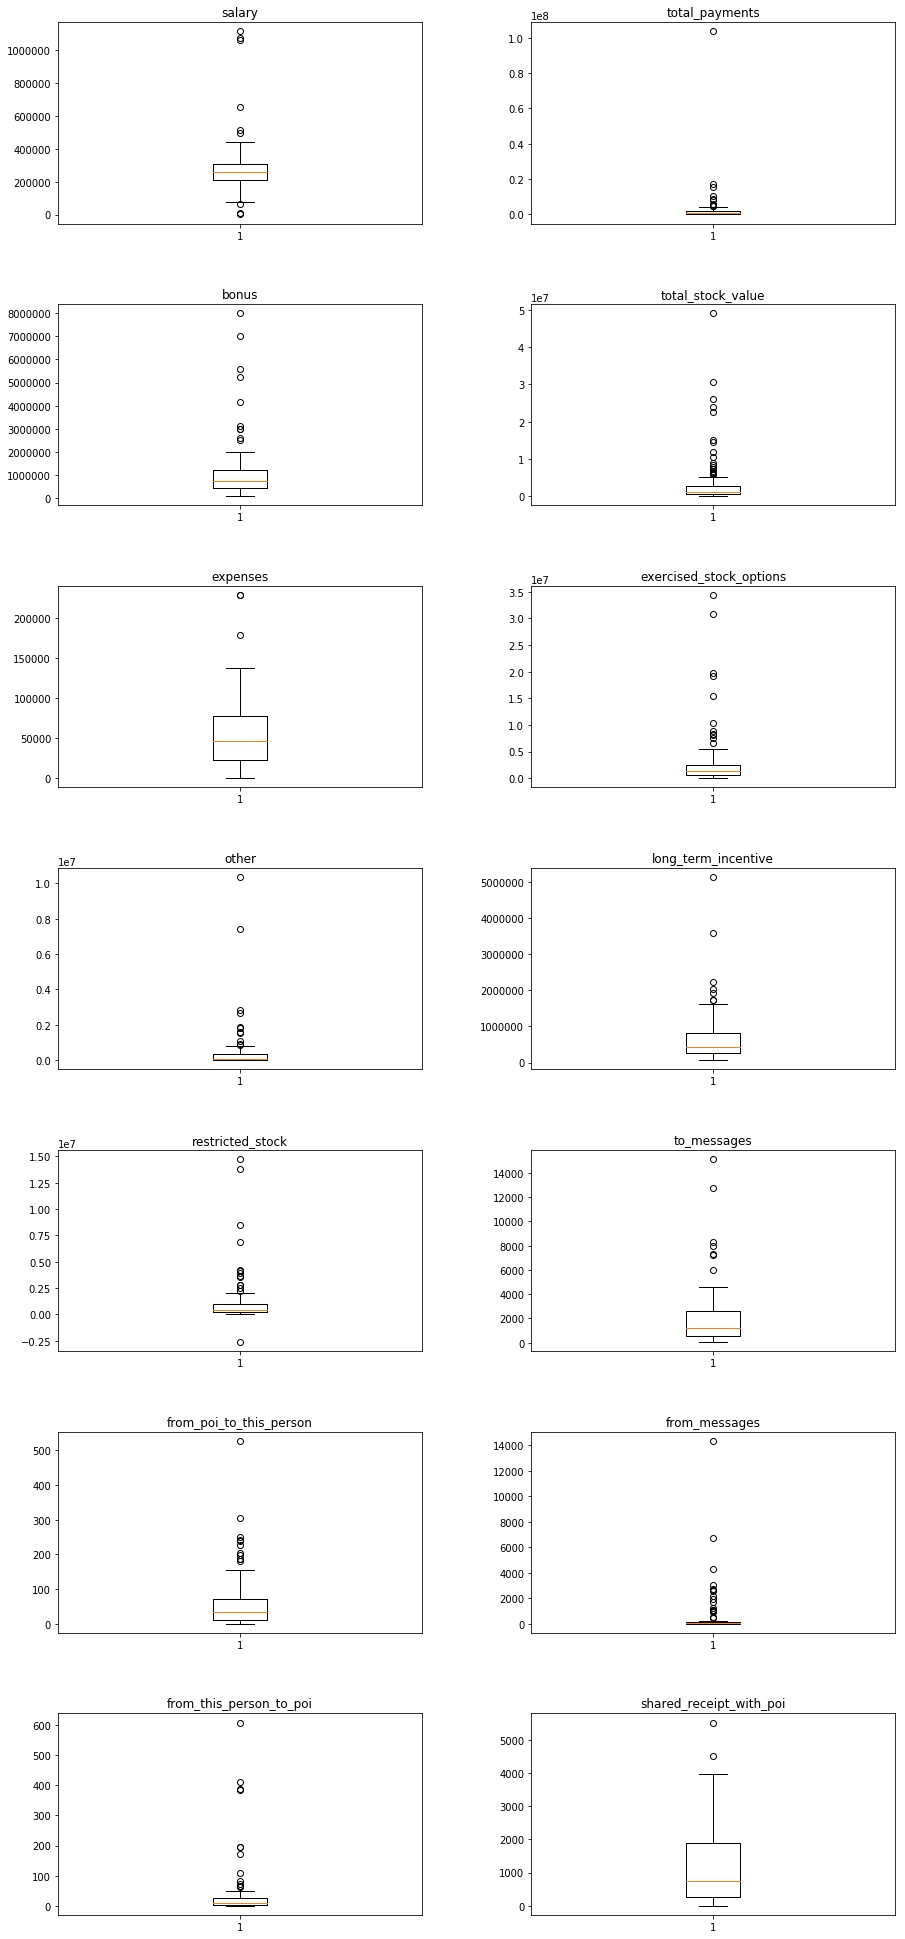

In [103]:
make_visualisations(df, valid_features, 'boxplot')

In [104]:
outliers(df, valid_features[0])

,full_name,salary
2,BANNANTINE JAMES M,477.0
57,GRAY RODNEY,6615.0
137,WESTFAHL RICHARD K,63744.0
32,DERRICK JR. JAMES V,492375.0
139,WHALLEY LAWRENCE G,510364.0
105,PICKERING MARK R,655037.0
47,FREVERT MARK A,1060932.0
79,LAY KENNETH L,1072321.0
122,SKILLING JEFFREY K,1111258.0


In [105]:
outliers(df, valid_features[1])

,full_name,total_payments
139,WHALLEY LAWRENCE G,4677574.0
31,DELAINEY DAVID W,4747979.0
7,BELDEN TIMOTHY N,5501630.0
3,BAXTER JOHN C,5634343.0
86,MARTIN AMANDA K,8407016.0
122,SKILLING JEFFREY K,8682716.0
78,LAVORATO JOHN J,10425757.0
11,BHATNAGAR SANJAY,15456290.0
47,FREVERT MARK A,17252530.0
79,LAY KENNETH L,103559793.0


In [106]:
outliers(df, valid_features[2])

,full_name,bonus
42,FALLON JAMES B,2500000.0
91,MCMAHON JEFFREY,2600000.0
31,DELAINEY DAVID W,3000000.0
139,WHALLEY LAWRENCE G,3000000.0
75,KITCHEN LOUISE,3100000.0
0,ALLEN PHILLIP K,4175000.0
7,BELDEN TIMOTHY N,5249999.0
122,SKILLING JEFFREY K,5600000.0
79,LAY KENNETH L,7000000.0
78,LAVORATO JOHN J,8000000.0


In [107]:
outliers(df, valid_features[3])

,full_name,total_stock_value
69,IZZO LAWRENCE L,5819980.0
134,WALLS JR ROBERT H,5898997.0
24,CHRISTODOULOU DIOMEDES,6077885.0
139,WHALLEY LAWRENCE G,6079137.0
73,KEAN STEVEN J,6153642.0
59,HANNON KEVIN P,6391065.0
41,ELLIOTT STEVEN,6678735.0
66,HORTON STANLEY C,7256648.0
102,OVERDYKE JR JERE C,7307594.0
110,REDMOND BRIAN L,7890324.0


In [108]:
outliers(df, valid_features[4])

,full_name,expenses
116,SHANKMAN JEFFREY A,178979.0
132,URQUHART JOHN A,228656.0
88,MCCLELLAN GEORGE,228763.0


In [109]:
outliers(df, valid_features[5])

,full_name,exercised_stock_options
3,BAXTER JOHN C,6680544.0
110,REDMOND BRIAN L,7509039.0
35,DIMICHELE RICHARD G,8191755.0
144,YEAGER F SCOTT,8308552.0
32,DERRICK JR. JAMES V,8831913.0
47,FREVERT MARK A,10433518.0
103,PAI LOU L,15364167.0
122,SKILLING JEFFREY K,19250000.0
112,RICE KENNETH D,19794175.0
65,HIRKO JOSEPH,30766064.0


In [110]:
outliers(df, valid_features[6])

,full_name,other
2,BANNANTINE JAMES M,864523.0
77,KOPPER MICHAEL J,907502.0
140,WHITE JR THOMAS E,1085463.0
69,IZZO LAWRENCE L,1553729.0
119,SHELBY REX,1573324.0
103,PAI LOU L,1829457.0
121,SHERRIFF JOHN R,1852186.0
3,BAXTER JOHN C,2660303.0
86,MARTIN AMANDA K,2818454.0
47,FREVERT MARK A,7427621.0


In [111]:
outliers(df, valid_features[7])

,full_name,long_term_incentive
98,MULLER MARK S,1725545.0
43,FASTOW ANDREW S,1736055.0
122,SKILLING JEFFREY K,1920000.0
78,LAVORATO JOHN J,2035380.0
40,ECHOLS JOHN B,2234774.0
79,LAY KENNETH L,3600000.0
86,MARTIN AMANDA K,5145434.0


In [112]:
outliers(df, valid_features[8])

,full_name,restricted_stock
11,BHATNAGAR SANJAY,-2604490.0
60,HAUG DAVID L,2217299.0
22,CAUSEY RICHARD A,2502063.0
112,RICE KENNETH D,2748364.0
139,WHALLEY LAWRENCE G,2796177.0
144,YEAGER F SCOTT,3576206.0
69,IZZO LAWRENCE L,3654808.0
3,BAXTER JOHN C,3942714.0
73,KEAN STEVEN J,4131594.0
47,FREVERT MARK A,4188667.0


In [113]:
outliers(df,'restricted_stock_deferred')

,full_name,restricted_stock_deferred
32,DERRICK JR. JAMES V,-1787380.0
11,BHATNAGAR SANJAY,15456290.0


In [114]:
df.query('full_name == "BHATNAGAR SANJAY"').iloc[0]

full_name                              BHATNAGAR SANJAY
salary                                              NaN
to_messages                                         523
deferral_payments                                   NaN
total_payments                              1.54563e+07
loan_advances                                       NaN
bonus                                               NaN
email_address                sanjay.bhatnagar@enron.com
restricted_stock_deferred                   1.54563e+07
deferred_income                                     NaN
total_stock_value                                   NaN
expenses                                            NaN
from_poi_to_this_person                               0
exercised_stock_options                     2.60449e+06
from_messages                                        29
other                                            137864
from_this_person_to_poi                               1
poi                                             

In [115]:
# correct entry for BHATNAGAR SANJAY
[(n,c) for n,c in enumerate(df.columns)]

[(0, 'full_name'),
 (1, 'salary'),
 (2, 'to_messages'),
 (3, 'deferral_payments'),
 (4, 'total_payments'),
 (5, 'loan_advances'),
 (6, 'bonus'),
 (7, 'email_address'),
 (8, 'restricted_stock_deferred'),
 (9, 'deferred_income'),
 (10, 'total_stock_value'),
 (11, 'expenses'),
 (12, 'from_poi_to_this_person'),
 (13, 'exercised_stock_options'),
 (14, 'from_messages'),
 (15, 'other'),
 (16, 'from_this_person_to_poi'),
 (17, 'poi'),
 (18, 'long_term_incentive'),
 (19, 'shared_receipt_with_poi'),
 (20, 'restricted_stock'),
 (21, 'director_fees'),
 (22, 'missing_cols')]

In [116]:
nan_cols = [1,6,18,9,3,5,15,21]
valid_cols=[11,4,13,20,8,10]
cols_values=[137864, 137864, 15456290, 2604490, -2604490, 15456290]

In [117]:
df.iloc[11,nan_cols]=np.nan
df.iloc[11,nan_cols]

salary                 NaN
bonus                  NaN
long_term_incentive    NaN
deferred_income        NaN
deferral_payments      NaN
loan_advances          NaN
other                  NaN
director_fees          NaN
Name: 11, dtype: object

In [118]:
df.iloc[11,valid_cols]=cols_values
df.iloc[11,valid_cols]

expenses                          137864
total_payments                    137864
exercised_stock_options      1.54563e+07
restricted_stock             2.60449e+06
restricted_stock_deferred   -2.60449e+06
total_stock_value            1.54563e+07
Name: 11, dtype: object

In [119]:
df.iloc[11]

full_name                              BHATNAGAR SANJAY
salary                                              NaN
to_messages                                         523
deferral_payments                                   NaN
total_payments                                   137864
loan_advances                                       NaN
bonus                                               NaN
email_address                sanjay.bhatnagar@enron.com
restricted_stock_deferred                  -2.60449e+06
deferred_income                                     NaN
total_stock_value                           1.54563e+07
expenses                                         137864
from_poi_to_this_person                               0
exercised_stock_options                     1.54563e+07
from_messages                                        29
other                                               NaN
from_this_person_to_poi                               1
poi                                             

# Features

<div class="alert alert-block alert-info">
<h2>Features</h2>
<br>
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]
</div>

**Features Used**<br>
I tested the model through with two different feature selection techniques. First I selected all features where at least 40% of the data was available and then I used an automatic feature selection function to compare results.

**Feature Engineering**


In [120]:
features_list = ['poi']+valid_features

In [121]:
# proportion of received messages from poi out of total received messages
# and sent messages to poi out of total sent messages
df['from_poi_proportion']=df.from_poi_to_this_person/df.from_messages
df['to_poi_proportion']=df.from_this_person_to_poi/df.to_messages

In [122]:
# bonus to salary ratio
df['bonus_to_salary']=df.bonus/df.salary

In [123]:
# restricted stock as a proportion of total stock value
df['restricted_to_total_stock']=df.restricted_stock/df.total_stock_value

In [124]:
# updated features list
features_list = features_list + ['from_poi_proportion','to_poi_proportion',
                                 'bonus_to_salary','restricted_to_total_stock']

In [127]:
df[features_list].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 145
Data columns (total 19 columns):
poi                          144 non-null bool
salary                       144 non-null float64
total_payments               144 non-null float64
bonus                        144 non-null float64
total_stock_value            144 non-null float64
expenses                     144 non-null float64
exercised_stock_options      144 non-null float64
other                        144 non-null float64
long_term_incentive          144 non-null float64
restricted_stock             144 non-null float64
to_messages                  144 non-null float64
from_poi_to_this_person      144 non-null float64
from_messages                144 non-null float64
from_this_person_to_poi      144 non-null float64
shared_receipt_with_poi      144 non-null float64
from_poi_proportion          144 non-null float64
to_poi_proportion            144 non-null float64
bonus_to_salary              144 non-null float6

In [128]:
df.fillna(0, inplace=True)

In [129]:
### df to dict
my_dataset=df.set_index('full_name').to_dict(orient='index')

In [130]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [131]:
data.shape, labels.shape, features.shape

((143, 19), (143,), (143, 18))

In [132]:
from sklearn import feature_selection

In [133]:
selec = feature_selection.SelectKBest()

In [134]:
selec.fit(features_train, labels_train)

SelectKBest(k=10, score_func=<function f_classif at 0x1a1b56bb70>)

# Classifiers

<div class="alert alert-block alert-info">
<h2>Classifiers</h2>
<br>
What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms? [relevant rubric item: “pick an algorithm”]
</div>

In [45]:
from sklearn import model_selection
from sklearn import metrics

In [46]:
features_train, features_test, labels_train, labels_test = \
    model_selection.train_test_split(features, labels, test_size=0.3, 
                                     random_state=42)

### Naive Bayes

In [47]:
from sklearn.naive_bayes import GaussianNB

In [48]:
clf = GaussianNB()

In [49]:
clf.fit(features_train, labels_train)

GaussianNB(priors=None)

In [50]:
preds = clf.predict(features_test)

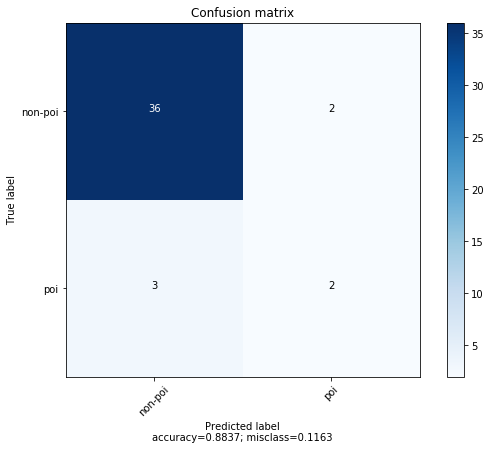

In [51]:
cm = metrics.confusion_matrix(labels_test, preds)
plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False)

In [52]:
print('recall: ',metrics.recall_score(labels_test, preds))
print('precision: ', metrics.precision_score(labels_test, preds))

recall:  0.4
precision:  0.5


### SVM

In [53]:
from sklearn.svm import SVC

In [54]:
# Grid search code original source:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
tuned_parameters = [{'kernel':['rbf','poly', 'sigmoid'],
                     'gamma': [1e-3, 1e-4],
                     'C': [1,10,100,1000]}]

In [55]:
clf = model_selection.GridSearchCV(SVC(), tuned_parameters, 
                                   return_train_score=True)

In [56]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [57]:
clf.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

In [58]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print('best parameters: ', clf.best_params_)
print()
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

best parameters:  {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

0.870 (+/-0.024) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.770 (+/-0.172) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.830 (+/-0.074) for {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.870 (+/-0.024) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.750 (+/-0.125) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.830 (+/-0.074) for {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.870 (+/-0.024) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.770 (+/-0.172) for {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}
0.830 (+/-0.074) for {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.870 (+/-0.024) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.750 (+/-0.125) for {'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}
0.830 (+/-0.074) for {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.870 (+/-0.024) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.770 (+/-0.172) for {'C': 100, 'gamma': 0.001, 'kernel': 'poly'}
0.830 (+/-0.074) for

In [59]:
preds = clf.predict(features_test)

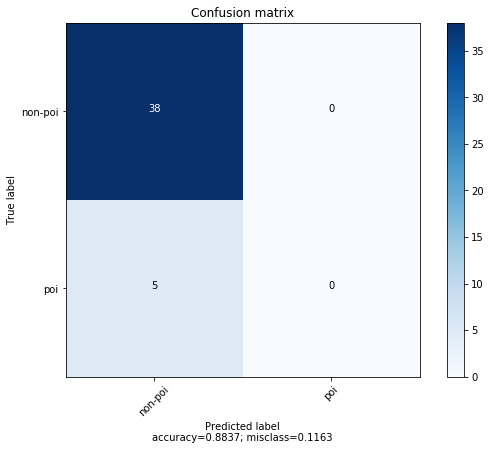

In [60]:
cm = metrics.confusion_matrix(labels_test, preds)
plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False)

In [61]:
print('recall: ',metrics.recall_score(labels_test, preds))
print('precision: ', metrics.precision_score(labels_test, preds))

recall:  0.0
precision:  0.0


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### K Nearest Neighbours

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
tuned_parameters = [{'n_neighbors':[1,2,3,4,5]}]

In [64]:
clf = model_selection.GridSearchCV(KNeighborsClassifier(), tuned_parameters,
                                   return_train_score=True)

In [65]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [66]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print('best parameters: ', clf.best_params_)
print()
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

best parameters:  {'n_neighbors': 2}

0.820 (+/-0.258) for {'n_neighbors': 1}
0.880 (+/-0.046) for {'n_neighbors': 2}
0.880 (+/-0.049) for {'n_neighbors': 3}
0.870 (+/-0.024) for {'n_neighbors': 4}
0.870 (+/-0.024) for {'n_neighbors': 5}



In [67]:
preds = clf.predict(features_test)

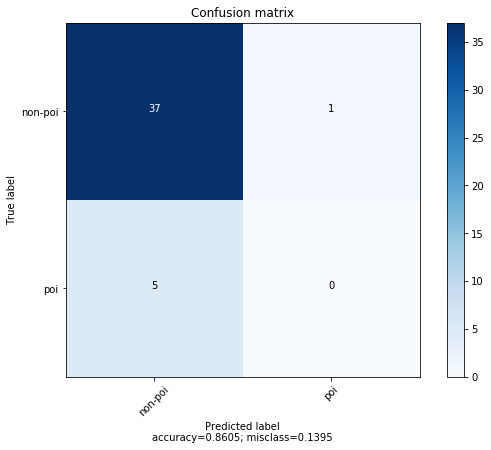

In [68]:
cm = metrics.confusion_matrix(labels_test, preds)
plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False)

In [69]:
print('recall: ',metrics.recall_score(labels_test, preds))
print('precision: ', metrics.precision_score(labels_test, preds))

recall:  0.0
precision:  0.0


### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
tuned_parameters=[{'n_estimators':[2,4,6,8,10,20],
                   'min_samples_split':[2,4,6,10]}]

In [72]:
clf = model_selection.GridSearchCV(RandomForestClassifier(),
                                   tuned_parameters, return_train_score=True)

In [73]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [2, 4, 6, 8, 10, 20], 'min_samples_split': [2, 4, 6, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [74]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print('best parameters: ', clf.best_params_)
print()
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

best parameters:  {'min_samples_split': 4, 'n_estimators': 10}

0.840 (+/-0.108) for {'min_samples_split': 2, 'n_estimators': 2}
0.860 (+/-0.075) for {'min_samples_split': 2, 'n_estimators': 4}
0.830 (+/-0.136) for {'min_samples_split': 2, 'n_estimators': 6}
0.850 (+/-0.049) for {'min_samples_split': 2, 'n_estimators': 8}
0.850 (+/-0.045) for {'min_samples_split': 2, 'n_estimators': 10}
0.860 (+/-0.027) for {'min_samples_split': 2, 'n_estimators': 20}
0.860 (+/-0.075) for {'min_samples_split': 4, 'n_estimators': 2}
0.870 (+/-0.030) for {'min_samples_split': 4, 'n_estimators': 4}
0.860 (+/-0.027) for {'min_samples_split': 4, 'n_estimators': 6}
0.810 (+/-0.054) for {'min_samples_split': 4, 'n_estimators': 8}
0.890 (+/-0.031) for {'min_samples_split': 4, 'n_estimators': 10}
0.850 (+/-0.045) for {'min_samples_split': 4, 'n_estimators': 20}
0.790 (+/-0.099) for {'min_samples_split': 6, 'n_estimators': 2}
0.830 (+/-0.026) for {'min_samples_split': 6, 'n_estimators': 4}
0.820 (+/-0.124) for {

In [75]:
preds = clf.predict(features_test)

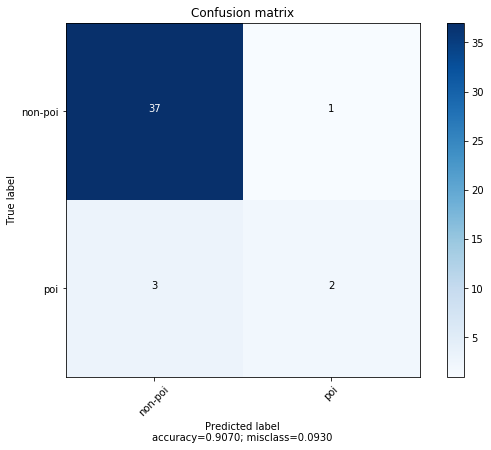

In [76]:
cm = metrics.confusion_matrix(labels_test, preds)
plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False)

In [77]:
print('recall: ',metrics.recall_score(labels_test, preds))
print('precision: ', metrics.precision_score(labels_test, preds))

recall:  0.4
precision:  0.6666666666666666


### AdaBoost

In [78]:
from sklearn.ensemble import AdaBoostClassifier

In [79]:
tuned_parameters = [{'n_estimators': [25, 50, 100],
                     'learning_rate': [.5, 1., 1.5]}]

In [80]:
clf = model_selection.GridSearchCV(AdaBoostClassifier(),
                                   tuned_parameters, return_train_score=True)

In [81]:
clf.fit(features_train, labels_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [25, 50, 100], 'learning_rate': [0.5, 1.0, 1.5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [82]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']

print('best parameters: ', clf.best_params_)
print()
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

best parameters:  {'learning_rate': 1.5, 'n_estimators': 50}

0.780 (+/-0.101) for {'learning_rate': 0.5, 'n_estimators': 25}
0.790 (+/-0.088) for {'learning_rate': 0.5, 'n_estimators': 50}
0.780 (+/-0.117) for {'learning_rate': 0.5, 'n_estimators': 100}
0.770 (+/-0.118) for {'learning_rate': 1.0, 'n_estimators': 25}
0.800 (+/-0.104) for {'learning_rate': 1.0, 'n_estimators': 50}
0.770 (+/-0.104) for {'learning_rate': 1.0, 'n_estimators': 100}
0.820 (+/-0.132) for {'learning_rate': 1.5, 'n_estimators': 25}
0.830 (+/-0.071) for {'learning_rate': 1.5, 'n_estimators': 50}
0.820 (+/-0.088) for {'learning_rate': 1.5, 'n_estimators': 100}



In [83]:
preds = clf.predict(features_test)

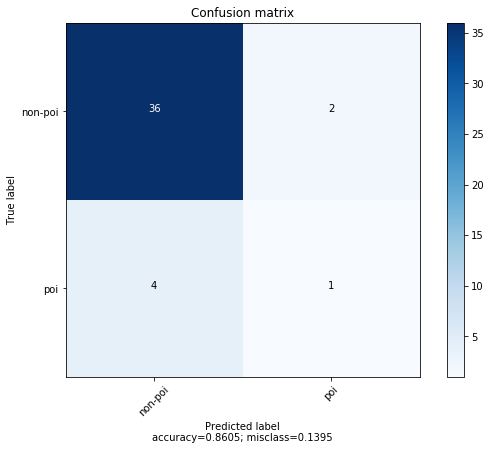

In [84]:
cm = metrics.confusion_matrix(labels_test, preds)
plot_confusion_matrix(cm, ['non-poi','poi'], normalize=False)

In [85]:
print('recall: ',metrics.recall_score(labels_test, preds))
print('precision: ', metrics.precision_score(labels_test, preds))

recall:  0.2
precision:  0.3333333333333333


## Task 5

In [86]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
#from sklearn.cross_validation import train_test_split
#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42)

## Task 6

In [87]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

#dump_classifier_and_data(clf, my_dataset, features_list)

## Questions

1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]



# Resources

* https://www.ibm.com/support/knowledgecenter/SSQNUZ_current/com.ibm.icpdata.doc/dsx/markd-jupyter.html
* https://datascience.stackexchange.com/questions/6838/when-to-use-random-forest-over-svm-and-vice-versa?newreg=9993c5ac29264444af406d7de90a1751
* https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
* https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7
* SKLearn Documentation